## General information
In this we work with the data from ventilators connected to a sedated patient's lung. Our goal is to simulate the ventilator and correctly predict the airway pressure in the respiratory circuit during the breath.

In [1]:
# libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

## Data loading and overview

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [4]:
# number of data points & number of features train dataset
train.shape

(6036000, 8)

In [5]:
# getting some information about thye dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6036000 entries, 0 to 6035999
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         int64  
 1   breath_id  int64  
 2   R          int64  
 3   C          int64  
 4   time_step  float64
 5   u_in       float64
 6   u_out      int64  
 7   pressure   float64
dtypes: float64(3), int64(5)
memory usage: 368.4 MB


In [6]:
# checking for missing values
train.isnull().sum()

id           0
breath_id    0
R            0
C            0
time_step    0
u_in         0
u_out        0
pressure     0
dtype: int64

In [7]:
train.describe()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
count,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06
mean,3.018000e+06,6.283886e+04,2.703618e+01,2.608072e+01,1.307225e+00,7.321615e+00,6.204493e-01,1.122041e+01
std,1.742443e+06,3.633526e+04,1.959549e+01,1.715231e+01,7.659778e-01,1.343470e+01,4.852752e-01,8.109703e+00
min,1.000000e+00,1.000000e+00,5.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-1.895744e+00
25%,1.509001e+06,3.137700e+04,5.000000e+00,1.000000e+01,6.428995e-01,3.936623e-01,0.000000e+00,6.329607e+00
50%,3.018000e+06,6.276550e+04,2.000000e+01,2.000000e+01,1.308123e+00,4.386146e+00,1.000000e+00,7.032628e+00
75%,4.527000e+06,9.430100e+04,5.000000e+01,5.000000e+01,1.965502e+00,4.983895e+00,1.000000e+00,1.364103e+01
max,6.036000e+06,1.257490e+05,5.000000e+01,5.000000e+01,2.937238e+00,1.000000e+02,1.000000e+00,6.482099e+01


The dataset is quite large - more than 6 lac rows. There are 2 categorical features (R and C), the id of a row, the id of a breath, timestamp are continuous variables.

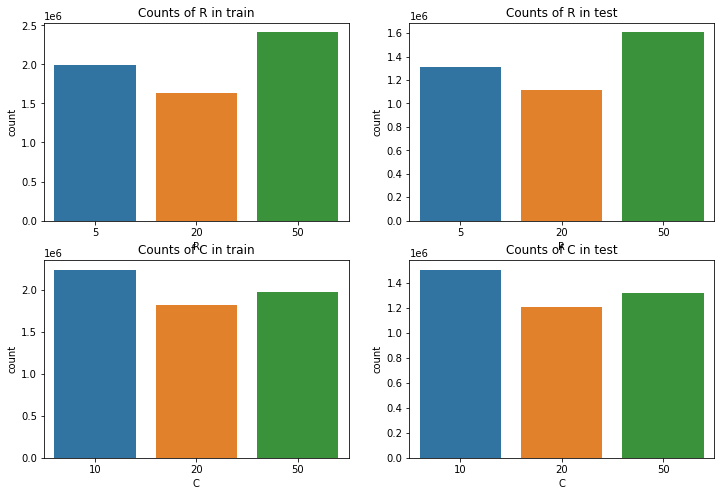

In [8]:
fig, ax = plt.subplots(figsize = (12, 8))
plt.subplot(2, 2, 1)
sns.countplot(x='R', data=train)
plt.title('Counts of R in train');
plt.subplot(2, 2, 2)
sns.countplot(x='R', data=test)
plt.title('Counts of R in test');
plt.subplot(2, 2, 3)
sns.countplot(x='C', data=train)
plt.title('Counts of C in train');
plt.subplot(2, 2, 4)
sns.countplot(x='C', data=test)
plt.title('Counts of C in test');

R and C categorical variables have a similar distribution in train and test data.

Now, let's have a look at one of the series in the data.

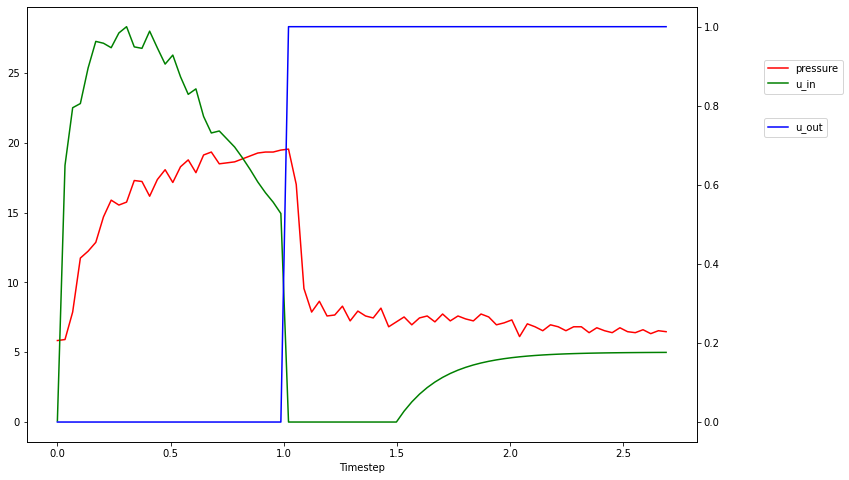

In [9]:
fig, ax1 = plt.subplots(figsize = (12, 8))

breath_1 = train.loc[train['breath_id'] == 1]
ax2 = ax1.twinx()

ax1.plot(breath_1['time_step'], breath_1['pressure'], 'r-', label='pressure')
ax1.plot(breath_1['time_step'], breath_1['u_in'], 'g-', label='u_in')
ax2.plot(breath_1['time_step'], breath_1['u_out'], 'b-', label='u_out')

ax1.set_xlabel('Timestep')

ax1.legend(loc=(1.1, 0.8))
ax2.legend(loc=(1.1, 0.7))
plt.show()

This is quite interesting: we can see that at first the pressure (our target) is rising and then, after the u_out becomes equal to 1, it has an abrupt drop.

In [10]:
# STORE PREDICTION RELEVANT COLUMNS
test_dataset_prediction_columns = test['id']

## Drop Irrelevant Columns
In the given input dataset there are 1 column that can be removed as follows: id

In [11]:
# Drop IRRELEVANT COLUMNS
train.drop(['id'], axis=1, inplace=True)
test.drop(['id'], axis=1, inplace=True)

## Target Column
The target column is the value which we need to predict. Therefore, we need to detach the target columns in prediction. Note that if we don't drop this fields, it will generate a model with high accuracy on training and worst accuracy on test (because the value in test dataset is Null). Here is the list of target column: pressure


In [12]:
#DETACH TARGET
feature_train = train.drop(['pressure'], axis=1)
target_train =train['pressure']
feature_test = test

## Training Model and Prediction
First, we will train a model based on preprocessed values of training data set. Second, let's predict test values based on the trained model

### Linear Regression

In [13]:
model=LinearRegression()
model.fit(feature_train, target_train) 
y_pred = model.predict(feature_test)

In [14]:
Prediction = pd.DataFrame(columns=['id'], data=test_dataset_prediction_columns)
Prediction['pressure'] = y_pred
Prediction.head()

,id,pressure
0,1,17.082262
1,2,17.408104
2,3,17.717050
3,4,18.001102
4,5,18.218719


### XGBoost Regressor
We will use XGBoost Regressor which is constructing a gradient boosting model.

In [16]:
# MODEL
model = XGBRegressor()
model.fit(feature_train, target_train) 
y_pred = model.predict(feature_test)

## Prediction File
We have to maintain the target columns in "Final_Prediction.csv" which will be submitted as our prediction results.

In [17]:
Prediction = pd.DataFrame(columns=['id'], data=test_dataset_prediction_columns)
Prediction['pressure'] = y_pred
Prediction.head()

,id,pressure
0,1,6.354721
1,2,6.001043
2,3,6.337477
3,4,8.390267
4,5,10.030748


In [18]:
# save prediction file
Prediction.to_csv("Final_Prediction.csv", index=False)